In [1]:
from __future__ import division, print_function

from itertools import product
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tqdm
import warnings

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

import scipy.stats as scs
from scipy.optimize import minimize

from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

warnings.filterwarnings('ignore')

/Users/alexander/.virtualenvs/ds-2019-03/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## 1. Скачать датасет Х.

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('input/AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## 2. Используя модель ARIMA из лекции, перебором подобрать наилучший набор параметров.

In [3]:
ts = data['#Passengers']
ts.head(10)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
Name: #Passengers, dtype: int64

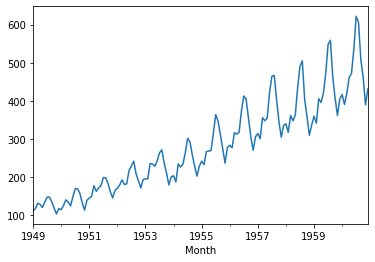

In [4]:
ts.plot()

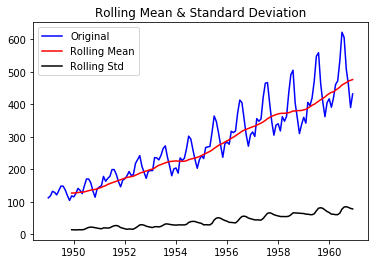

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [5]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Задаем скользящие
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Отрисовываем
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Выполняем тест Дики-Фуллера
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    
test_stationarity(ts)

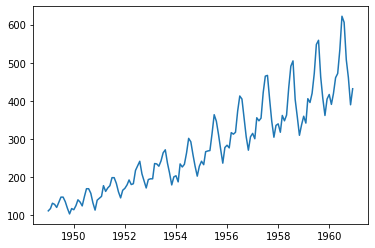

In [6]:
plt.plot(ts)

In [7]:
ts_log = np.log(ts)

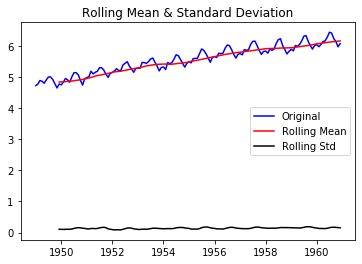

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [8]:
test_stationarity(ts_log)

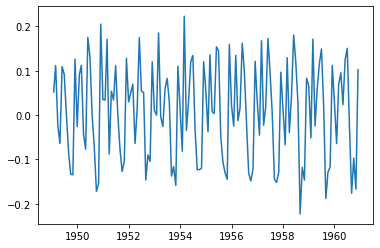

In [9]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

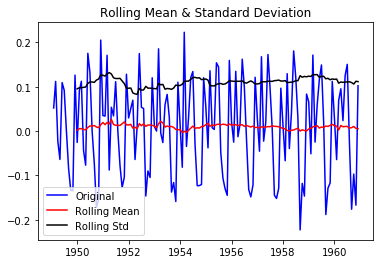

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [10]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

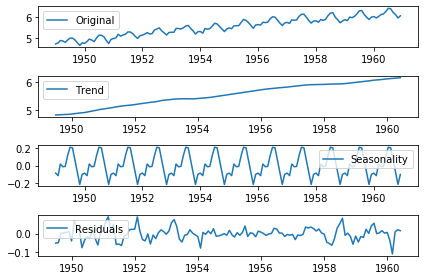

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

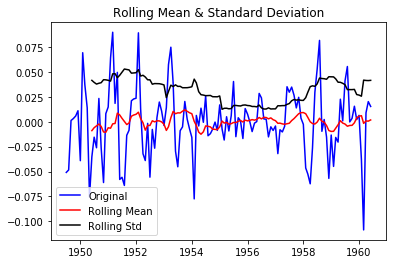

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [12]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

In [13]:
from statsmodels.tsa.stattools import acf, pacf

In [14]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

In [15]:
q = 2
p = 2

In [16]:
from statsmodels.tsa.arima_model import ARIMA  # (p,d,q)

Text(0.5, 1.0, 'RSS: 1.0292')

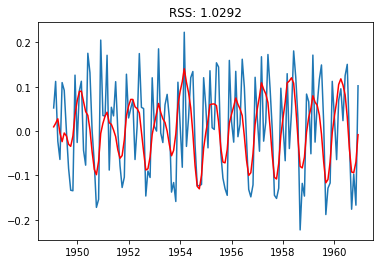

In [17]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

Text(0.5, 1.0, 'RMSE: 90.1047')

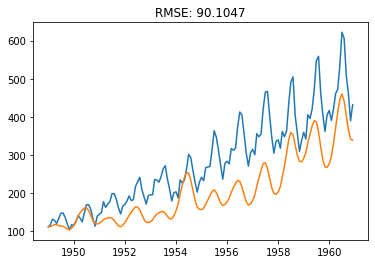

In [18]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

In [99]:
def revert(results_ARIMA):
    predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
    predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
    predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
    predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
    predictions_ARIMA = np.exp(predictions_ARIMA_log)

    return predictions_ARIMA

def revert_log(results_ARIMA):
    predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
    predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
    predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
    predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
    return predictions_ARIMA_log

#     predictions_ARIMA = np.exp(predictions_ARIMA_log)

#     return predictions_ARIMA

In [117]:
# p = range(0, 3)
# d = (1,)
# q = range(0, 2)

p = range(0, 3)
# d = (1,)
d = range(1, 13)
q = range(0, 3)



from itertools import product

parameters = product(p, d, q)
parameters_list = list(parameters)
len(parameters_list)

108

In [118]:
from statsmodels.tsa.seasonal import seasonal_decompose

src_cs = seasonal_decompose(ts_log)

orders = []
print('T', src_cs.trend)
print('S', src_cs.seasonal)
# print('R', src_cs.residual)

def calc_rss(p, d, q):
    model = ARIMA(ts_log, order=(p, d, q))  
    results_ARIMA = model.fit(disp=-1)  
    log = rveert_log(results_ARIMA)
    dst_cs = seasonal_decompose(log)

#     print('T', dst_cs.trend)
#     print('S', dst_cs.seasonal)
# #     print('R', dst_cs.residual)
    
    def err(a1, a2):
        return sum((a1 - a2)**2)
    
#     rss = sum((results_ARIMA.fittedvalues - ts_log_diff)**2)
    rss = err(results_ARIMA.fittedvalues, ts_log_diff)
    rss = sum([
#         err(src_cs.trend, dst_cs.trend),
        err(src_cs.seasonal, dst_cs.seasonal),
    ])
    
    return rss


for p, d, q in parameters_list:


    model = ARIMA(ts_log, order=(p, d, q))  
    results_ARIMA = model.fit(disp=-1)  
    
#     log = revert_log(results_ARIMA)
    
#     decomposition = seasonal_decompose(log)

#     print('LOG', log)
    
#     trend = decomposition.trend
#     seasonal = decomposition.seasonal
#     residual = decomposition.resid
#     print('T', trend)
#     print('S', seasonal)
#     print('R', residual)


    
#     rss = sum((results_ARIMA.fittedvalues - ts_log_diff)**2)
# #     rss = sum((revert(results_ARIMA) - ts)**2)
    rss = calc_rss(p, d, q) 
    orders.append((rss, p, d, q))
    print('for p={}, d={}, q={} RSS is {}'.format(p, d, q, rss))

    



T Month
1949-01-01   NaN
1949-02-01   NaN
1949-03-01   NaN
1949-04-01   NaN
1949-05-01   NaN
              ..
1960-08-01   NaN
1960-09-01   NaN
1960-10-01   NaN
1960-11-01   NaN
1960-12-01   NaN
Name: #Passengers, Length: 144, dtype: float64
S Month
1949-01-01   -0.085815
1949-02-01   -0.114413
1949-03-01    0.018113
1949-04-01   -0.013046
1949-05-01   -0.008966
                ...   
1960-08-01    0.204512
1960-09-01    0.064836
1960-10-01   -0.075271
1960-11-01   -0.215846
1960-12-01   -0.100315
Name: #Passengers, Length: 144, dtype: float64
for p=0, d=1, q=0 RSS is 2.2456749848683843
for p=0, d=1, q=1 RSS is 1.6064872300687592
for p=0, d=1, q=2 RSS is 1.9770351189466282
for p=0, d=2, q=0 RSS is 2.2456817457295557
for p=0, d=2, q=1 RSS is 7.492008565846546
for p=0, d=2, q=2 RSS is 5.8115455218676


ValueError: d > 2 is not supported

[(0.6579531225530934, 3, 1, 3),
 (0.699211781673426, 2, 1, 2),
 (0.7019280015836131, 5, 1, 4),
 (0.71396877730823, 2, 1, 3),
 (0.8024699718169449, 5, 1, 3),
 (0.8039038651847092, 4, 1, 4),
 (0.8191003091810231, 4, 1, 3),
 (0.9517619669507388, 5, 1, 2),
 (0.9768047698582248, 1, 1, 5),
 (0.9987633128170431, 4, 1, 2),
 (0.999622376293561, 4, 1, 1),
 (1.0320995673760742, 5, 1, 1),
 (1.1118572385839156, 2, 1, 4),
 (1.1124874370150584, 3, 1, 4),
 (1.1222952618179285, 3, 1, 1),
 (1.130271585636468, 2, 1, 5),
 (1.1452259813969918, 3, 1, 5),
 (1.165496999916832, 0, 1, 4),
 (1.16958204169526, 0, 1, 5),
 (1.1746682994976938, 1, 1, 4),
 (1.2047625493589098, 3, 1, 2),
 (1.216230139657336, 2, 1, 1),
 (1.4687194039995488, 1, 1, 3),
 (1.4780783766750507, 1, 1, 2),
 (1.6064872300687592, 0, 1, 1),
 (1.6217215603306285, 5, 1, 0),
 (1.622614496788672, 4, 1, 0),
 (1.7005038664980792, 1, 1, 1),
 (1.7222619386280682, 1, 1, 0),
 (1.744531644472671, 3, 1, 0),
 (1.753239971857005, 2, 1, 0),
 (1.7935324005059008

(0.009456072669824934, 0.008713587065505)

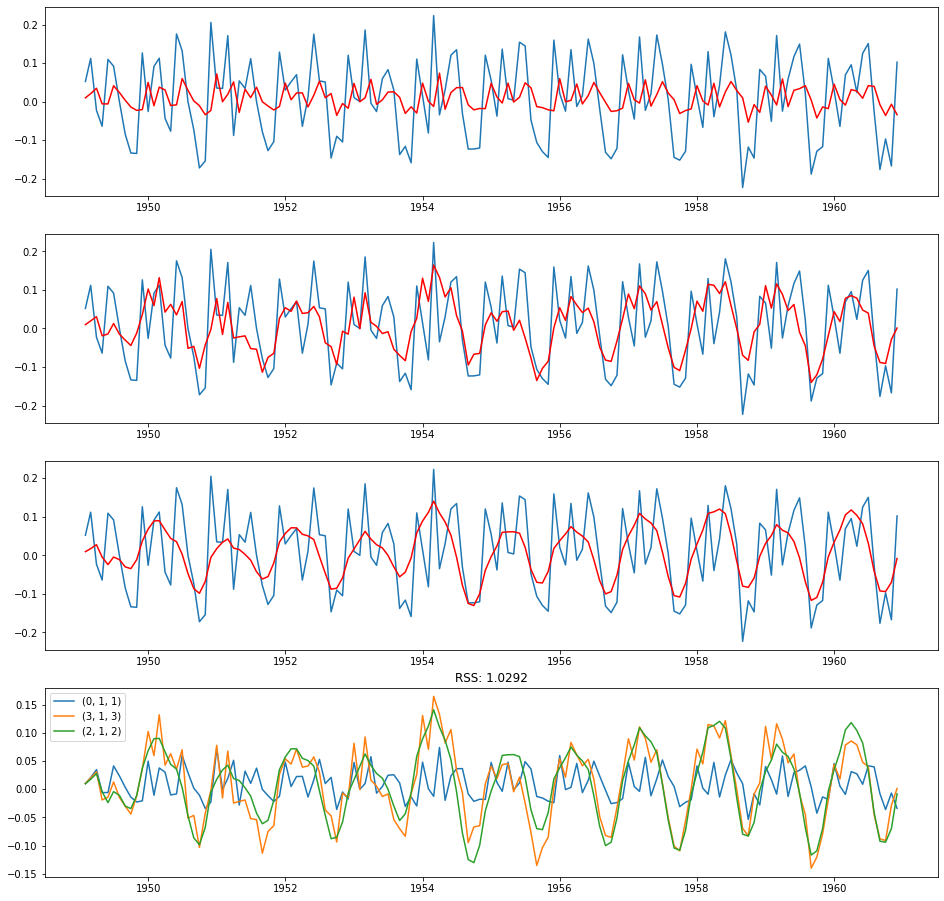

In [115]:
orders = sorted(orders)
display(orders)

suborders = [(0, 1, 1), (3,1,3), (2,1,2)]

f, ax = plt.subplots(len(suborders)+1, 1, figsize=(16, 16))
models = []
results = []
for i, order in enumerate(suborders):
    models.append(ARIMA(ts_log, order=order))
    results_ARIMA = models[i].fit(disp=-1)  
    results.append(results_ARIMA)
    
    ax[i].plot(ts_log_diff)
    ax[i].plot(results_ARIMA.fittedvalues, color='red')
    ax[len(suborders)].plot(results_ARIMA.fittedvalues, label=f'{str(order)}')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
plt.legend()

model = ARIMA(ts_log, order=(3, 1, 3))  
# model = ARIMA(ts_log, order=(4, 1, 4))  
results_ARIMA = model.fit(disp=-1)  

# f, ax = plt.subplots(1, 1, figsize=(16, 8))
# ax.plot(ts_log_diff)
# ax.plot(results_ARIMA.fittedvalues, color='red')
# plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

results
import pandas as pd
pd.Series(results[0].fittedvalues).mean(), pd.Series(results[1].fittedvalues).mean()

Text(0.5, 1.0, 'RMSE: 198.1774')

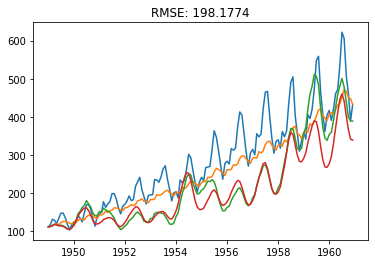

In [116]:
# # predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
# predictions_ARIMA_diff = pd.Series(results[1].fittedvalues, copy=True)
# predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
# predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
# predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
# predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
# plt.plot(predictions_ARIMA)
plt.plot(revert(results[0]))
plt.plot(revert(results[1]))
plt.plot(revert(results[2]))
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

In [25]:
# HE IS NUTTY 

# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import GridSearchCV



# from sklearn.base import BaseEstimator
# from statsmodels.tsa.stattools import adfuller
# from sklearn.metrics import mean_squared_error

# def revert(results_ARIMA):
#     predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
#     predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
#     predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
#     predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
#     predictions_ARIMA = np.exp(predictions_ARIMA_log)
# #     plt.plot(ts)
# #     plt.plot(predictions_ARIMA)
# #     plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))
#     return predictions_ARIMA

# class ArimaEstimator(BaseEstimator):  
#     def __init__(self, p, d, q, **kwargs):
#         self.p = p
#         self.d = d
#         self.q = q
    
#     def fit(self, X, y=None):
# #         print('FIT 1', X[:10])
#         self._orig_arima = ARIMA(X, order=(self.p, self.d, self.q))
#         self._results_arima = self._orig_arima.fit(disp=-1)  
#         print('FIT 2', self._results_arima.fittedvalues[:10])
# #         self.rss = sum((results_ARIMA.fittedvalues - ts_log_diff)**2)
        
# # # #         self.get_model_instance().fit(X, y)
# # # #         return self
# # # #         self.model_instance = models[self.name]
# # #         self.model_instance.fit(X, y)

#         return self

#     def predict(self, X, y=None):
# #         print('RES', self._results_arima)
# #         print('PREDICT', X.shape, X)
# #         print('REVERT', revert(self._results_arima))
# #         return revert(self._results_arima)
#         print('PREDICT X', X[:10])
#         print('PREDICT 3', self._results_arima.fittedvalues[:10])
#         return self._results_arima.fittedvalues
# #         return range(len(self._results_arima))
# #         return revert(self._results_arima)
        
# # # #         return self.get_model_instance().predict(X)
# # # #         self.model_instance = models[self.name]
# # #         return list(map(int, self.model_instance.predict(X)))
# #         return self.rss

    
#     def score(self, X, y=None):
# #         print('SCORE', X.shape, y.shape)
# #         print('PREDICTED', self.predict(X))
# #         error = mean_squared_error(self.predict(X), 1), y)
# #         n = self.predict(X).shape[0]
#         n = y.shape[0]
# #         print('X Y', list(zip(np.array(X)[:10], y[:10])))
# #         print('N', n)
#         error = mean_squared_error(np.array(X)[:n].reshape((n, 1)), y)
# #         print('ERROR', error)
#         score = 1 / (1 + error)
# #         print('SCORE', self.p, self.d, self.q, score)
# #         print('.', end='')
#         return score



# pipeline = Pipeline(steps = [
# # #     ('feature_selector', FunctionTransformer(feature_selector, validate=False)),

# # #     ('imputer', SimpleImputer(strategy='most_frequent')),
# # #     ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False)),
# # #     ('scaler', StandardScaler()),      
    
    
# # #     ('model', Router('log_reg', estimator=None, x_pred=x_test, y_true=y_true))
#         ('model', ArimaEstimator(p=3, d=1, q=3))
# ])

# print('L', list(range(1, 3)))

# grid = {
#     'model__p': range(0, 3),
#     'model__d': range(1, 2),
#     'model__q': range(0, 2),
# }



# # def estimator(model):
# #     print(model)
# # #         x = preparation.fit_transform(x_test)
# #     model.fit(_x_train, _y_train)
# # #         print(model.predict(x).shape, y_true.shape)
# #     return accuracy_score(y_pred=list(map(int, model.predict(_x_test))), y_true=_y_true)


# search_cv = GridSearchCV(pipeline, grid, cv=3, iid=True)
# # print('SHAPE', np.array(ts_log).shape)
# # print(np.array(ts_log).reshape((1, np.array(ts_log).shape[0])))
# # print('2')
# # search_cv.fit(np.array(ts_log).reshape((np.array(ts_log).shape[0], 1)), np.array(ts_log))
# search_cv.fit(ts_log, ts_log)

# x = list(ts)[:144]
# y = model.predict(ts_log)

# # display(len(x))
# # display(len(y))

# plt.plot(x)
# # plt.plot(model.predict([]))
# plt.plot(y)

# search_cv.best_estimator_

# # model = ArimaEstimator(p=3, d=1, q=3)
# # model.fit(ts_log)

# # plt.plot(ts)
# # plt.plot(model.predict([]))

# # model.score(X=model.predict([]), y=ts)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV



from sklearn.base import BaseEstimator
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

def revert(results_ARIMA):
    predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
    predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
    predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
    predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
    predictions_ARIMA = np.exp(predictions_ARIMA_log)
#     plt.plot(ts)
#     plt.plot(predictions_ARIMA)
#     plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))
    return predictions_ARIMA





class ArimaEstimator(BaseEstimator):  
    def __init__(self, p, d, q, **kwargs):
        self.p = p
        self.d = d
        self.q = q
    
    def fit(self, X, y=None):
#         print('FIT 1', X[:10])
        self._orig_arima = ARIMA(X, order=(self.p, self.d, self.q))
        self._results_arima = self._orig_arima.fit(disp=-1)  
        print('FIT 2', self._results_arima.fittedvalues[:10])
#         self.rss = sum((results_ARIMA.fittedvalues - ts_log_diff)**2)
        
# # #         self.get_model_instance().fit(X, y)
# # #         return self
# # #         self.model_instance = models[self.name]
# #         self.model_instance.fit(X, y)

        return self

    def predict(self, X, y=None):
#         print('RES', self._results_arima)
#         print('PREDICT', X.shape, X)
#         print('REVERT', revert(self._results_arima))
#         return revert(self._results_arima)
        print('PREDICT X', X[:10])
        print('PREDICT 3', self._results_arima.fittedvalues[:10])
        return self._results_arima.fittedvalues
#         return range(len(self._results_arima))
#         return revert(self._results_arima)
        
# # #         return self.get_model_instance().predict(X)
# # #         self.model_instance = models[self.name]
# #         return list(map(int, self.model_instance.predict(X)))
#         return self.rss

    
    def score(self, X, y=None):
#         print('SCORE', X.shape, y.shape)
#         print('PREDICTED', self.predict(X))
#         error = mean_squared_error(self.predict(X), 1), y)
#         n = self.predict(X).shape[0]
        n = y.shape[0]
#         print('X Y', list(zip(np.array(X)[:10], y[:10])))
#         print('N', n)
        error = mean_squared_error(np.array(X)[:n].reshape((n, 1)), y)
#         print('ERROR', error)
        score = 1 / (1 + error)
#         print('SCORE', self.p, self.d, self.q, score)
#         print('.', end='')
        return score



pipeline = Pipeline(steps = [
# #     ('feature_selector', FunctionTransformer(feature_selector, validate=False)),

# #     ('imputer', SimpleImputer(strategy='most_frequent')),
# #     ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False)),
# #     ('scaler', StandardScaler()),      
    
    
# #     ('model', Router('log_reg', estimator=None, x_pred=x_test, y_true=y_true))
        ('model', ArimaEstimator(p=3, d=1, q=3))
])

print('L', list(range(1, 3)))

grid = {
    'model__p': range(0, 3),
    'model__d': range(1, 2),
    'model__q': range(0, 2),
}



# def estimator(model):
#     print(model)
# #         x = preparation.fit_transform(x_test)
#     model.fit(_x_train, _y_train)
# #         print(model.predict(x).shape, y_true.shape)
#     return accuracy_score(y_pred=list(map(int, model.predict(_x_test))), y_true=_y_true)


search_cv = GridSearchCV(pipeline, grid, cv=3, iid=True)
# print('SHAPE', np.array(ts_log).shape)
# print(np.array(ts_log).reshape((1, np.array(ts_log).shape[0])))
# print('2')
# search_cv.fit(np.array(ts_log).reshape((np.array(ts_log).shape[0], 1)), np.array(ts_log))
search_cv.fit(ts_log, ts_log)

x = list(ts)[:144]
y = model.predict(ts_log)

# display(len(x))
# display(len(y))

plt.plot(x)
# plt.plot(model.predict([]))
plt.plot(y)

search_cv.best_estimator_

# model = ArimaEstimator(p=3, d=1, q=3)
# model.fit(ts_log)

# plt.plot(ts)
# plt.plot(model.predict([]))

# model.score(X=model.predict([]), y=ts)

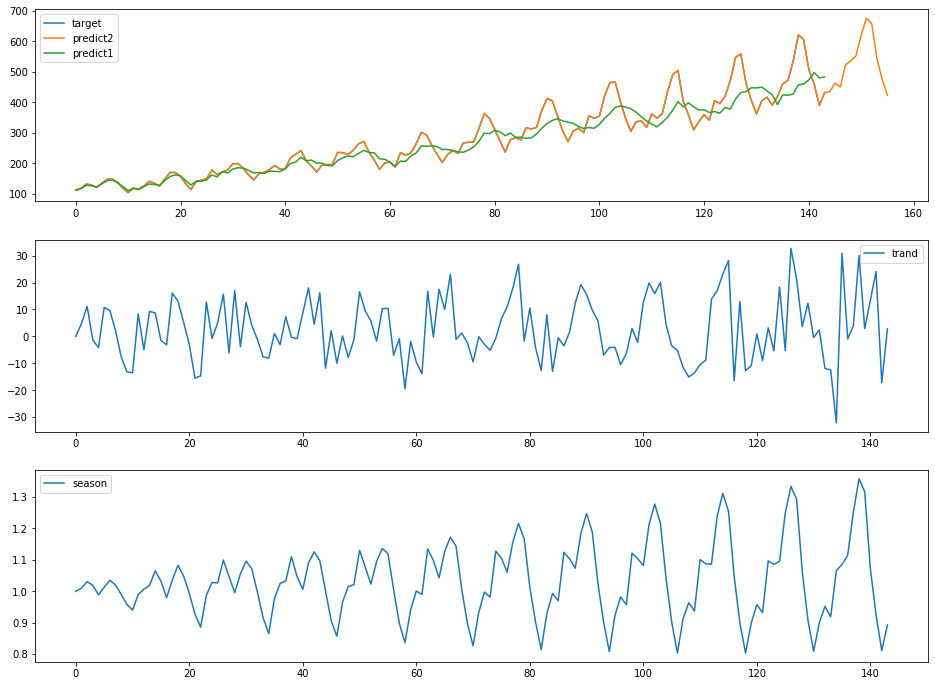

In [44]:
# from input import aslist as origin
# # l
# # f = (lambda self, a, i, l: a*l[i]+(1-a)*self(self, a, i-1, l) if i > 0 else l[0])
# # l2 = list(map(lambda i: f(f, 0.5, i, l), range(len(l))))
# # l2

# # plt.plot(l)
# # plt.plot(l2)

# # (lambda f, l: f(f, len(l)-1, l))(lambda self, i, l: 0.9*l[i]+0.1*self(self, i-1, l) if i > 0 else l[0], l)
# # (lambda f, y: f(f, len(l)-1, y))(lambda self, i, y: 0.9*y[i]+0.1*self(self, i-1, y) if i > 0 else y[0], y)

# y = list(origin)

# # # l3 = (lambda f, a, y: f(f, a, len(l)-1, y))(lambda self, a, i, y: a*y[i]+(1-a)*self(self, a, i-1, y) if i > 0 else y[0], 0.9, y)
# # l4 = (lambda a, y, f: [f(f, a, i, y) for i in range(len(y))])(0.3, y, lambda self, a, i, y: a*y[i]+(1-a)*self(self, a, i-1, y) if i > 0 else y[0])
# # plt.plot(l)
# # plt.plot(l4)


# # def double_exponential_smoothing(y, alpha, beta):
# #     l = [y[0]]
# #     b = [1]
# #     for i, y_i in enumerate(y[1:], start=1):
# # #         l.append(alpha*y[i]+(1-alpha)*l[i-1])
# #         l.append(alpha*y[i]+(1-alpha)*(l[i-1]+b[i-1]))
# #         b.append(beta*(l[i]-l[i-1])+(1-beta)*(b[i-1]))
# #     return l

# # l5 = double_exponential_smoothing(y, 0.02, 0.9)

# # plt.plot(l)
# # plt.plot(l5)


# # def triple_exponential_smoothing(y, alpha, beta, k, q):
# #     l = [y[0]]
# #     b = [0]
# #     s = [1]
# #     for i, y_i in enumerate(y[1:], start=1):
# #         s_i = 0 if i < 12 else i - 12
# #         display(f'{s_i}, {len(s)}')
# #         s_ = s[s_i]
        
# # # #         l.append(alpha*y[i]+(1-alpha)*l[i-1])
# # #         l.append(alpha*y[i]+(1-alpha)*(l[i-1]+b[i-1]))
# # #         b.append(beta*(l[i]-l[i-1])+(1-beta)*(b[i-1]))
# # #         l.append(alpha*y[i]/s[i-s_i])
# #         l.append((k)*y[i]/s_ + (1-k)*(l[i-1]-b[i-1]))
# #         b.append(beta*(l[i]-l[i-1])+(1-beta)*(b[i-1]))
# #         s.append(q*y[i]/l[i]+(1-q)*s_)
# # #         print('L', l[i])
# # #         print('/', y[i]/l[i])
# # #         print('S', s[-1])
# # #         print('S_', s_)

# #     return l, b, s

# # l6, b, s = triple_exponential_smoothing(y, 0.9, 0.9, 0.5, 0.5)

# # f, ax = plt.subplots(1, 1, figsize=(16, 8))

# # ax.plot(l, label='target')
# # ax.plot(l6, label='predict')
# # ax.plot(b, label='trand')
# # ax.plot(s, label='season')

# # plt.legend()

from input import aslist as origin

y = list(origin)

def triple_exponential_smoothing(y, alpha, beta, k, q):
    pred = list(y)
    l = [y[0]]
    b = [0]
    s = [1]
    last = 0
    for i, y_i in enumerate(y[1:], start=1):
# #         s_i = 1 if i <= 12 else 12
# #         s_prev = s[i-s_i]

# #         s_i = 1 if i <= 12 else 12
# #         s_prev = s[i-(1 if i <= 12 else 12)]
#         s_prev = s[i-12] if i >= 12 else 1
        
# #         display(s_)
        
        
# # #         l.append(alpha*y[i]+(1-alpha)*l[i-1])
# #         l.append(alpha*y[i]+(1-alpha)*(l[i-1]+b[i-1]))
# #         b.append(beta*(l[i]-l[i-1])+(1-beta)*(b[i-1]))
# #         l.append(alpha*y[i]/s[i-s_i])
#         l.append((k)*y[i]/s_prev + (1-k)*(l[i-1]-b[i-1]))
#         b.append(beta*(l[i]-l[i-1])+(1-beta)*(b[i-1]))
#         s.append(q*y[i]/l[i]+(1-q)*s_prev)
# #         print('L', l[i])
# #         print('/', y[i]/l[i])
# #         print('S', 8-1])
# #         print('S_', s_)
# #         s_i = 1 if i <= 12 else 12
# #         s_prev = s[i-s_i]

# #         s_i = 1 if i <= 12 else 12
# #         s_prev = s[i-(1 if i <= 12 else 12)]
        
        s_prev = s[i-12] if i >= 12 else 1
        l.append((k)*y[i]/s_prev + (1-k)*(l[i-1]-b[i-1]))
        b.append(beta*(l[i]-l[i-1])+(1-beta)*(b[i-1]))
        s.append(q*y[i]/l[i]+(1-q)*s_prev)

        last = i
        
    l_last = l[last]
    b_last = b[last]
    
#     for i in range(len(l)+12, start=len(l)):
    for j in range(12):
        i = last + j
        s_prev = s[last-12+j]
        pred.append(s_prev * l_last + j * b_last)
#         l.append((k)*y[i]/s_prev + (1-k)*(l[i-1]-b[i-1]))
#         b.append(beta*(l[i]-l[i-1])+(1-beta)*(b[i-1]))
#         s.append(q*y[i]/l[i]+(1-q)*s_prev)        


    return pred, l, b, s

        
        
y_pred, l6, b, s = triple_exponential_smoothing(y, 0.99, 0.99, 0.8, 0.99)

f, ax = plt.subplots(3, 1, figsize=(16, 12))

ax[0].plot(y, label='target')
ax[0].plot(y_pred, label='predict2')
ax[0].plot(l6, label='predict1')
ax[1].plot(b, label='trand')
ax[2].plot(s, label='season')

[a.legend() for a in ax]
